# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [ ]:
# Harry Potter -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2023-12-10 19:33:41--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2023-12-10 19:33:42--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.78M  --.-KB/s    in 0.08s   

2023-12-10 19:33:42 (207 MB/s) - ‘data.zip’ saved [17592727/17592727]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch.nn.functional as F

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):  #хотим получить ббоксы по корню
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml") #залезли в xml дерево
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        res =  [int(member[4][0].text), int(member[4][1].text), int(member[4][2].text),
                int(member[4][3].text), class_dict[member[0].text]]
        bboxes.append(res)
    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform,root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform
        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}  #словарь снич: 1, квофл: 2, бладгер: 3
        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
mean_inv = (-0.485, -0.456, -0.406)
std_inv = (1/0.229, 1/0.244, 1/ 0.225)
train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

/content/data/xmls/0.xml
/content/data



In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

**train_ds.filenames** ['./data//images/109.jpg', './data//images/130.jpg',
 './data//images/258.jpg', './data//images/213.jpg',
 './data//images/127.jpg', './data//images/238.jpg',
 './data//images/50.jpg', './data//images/114.jpg', ...]

**train_ds.root** PosixPath('data')

**train_ds.class_dict** {'snitch': 0, 'quaffle': 1, 'bludger': 2}

**train_ds.class_dict_inv** {0: 'snitch', 1: 'quaffle', 2: 'bludger'}

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [ ]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100)
    for i, ax in enumerate(axes.reshape(-1)):
        ax.axis(False)

        if i >= len(images):
          break
        for j in range(3):
          images[i][j] = (images[i][j] * std[j]) + mean[j]
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv
        ax.imshow(images[i].squeeze().permute(1, 2, 0))

        for bbox in bboxes[i]:
          if bbox[4] == 0:
            p = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                              fill = False, color = "green", label = train_ds.class_dict_inv[0])
            ax.add_patch(p)
            ax.text(bbox[0] + 5, bbox[1] - 5, train_ds.class_dict_inv[0], color = "green", fontsize=8)
          elif bbox[4] == 1:
            p = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                              fill = False, color = "blue", label = train_ds.class_dict_inv[1])
            ax.add_patch(p)
            ax.text(bbox[0] + 5, bbox[1] - 5, train_ds.class_dict_inv[1], color = "blue", fontsize=8)
          else:
            p = plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                              fill = False, color = "red", label = train_ds.class_dict_inv[2])
            ax.add_patch(p)
            ax.text(bbox[0] + 5, bbox[1] - 5, train_ds.class_dict_inv[2], color = "red", fontsize=8)

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])


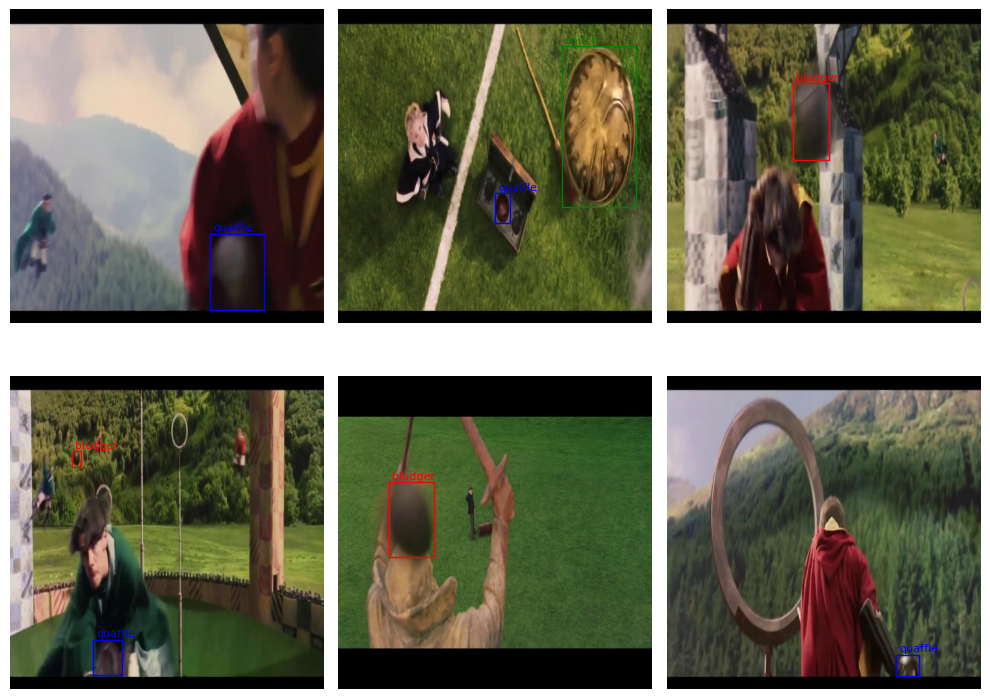

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO

Сейчас нам предстоить реализовать YOLO детектор. Это один из самых простых детекторов с точки зрения реализации. Он описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Мы будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16. В каждом пикселе мы будем предсказывать размеры прямоугольника и класс.



We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности. В каналах у нас будут записаны координаты центра, центр относительно координат пикселя, бинарная переменная (детекция присутствует), класс детекции.

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))
    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape
    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)
    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )
        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        w_box =  (xmax - xmin)/w # TODO ширина бокса отнормированная
        h_box =  (ymax - ymin)/h # TODO высота бокса отнормированная

        # Посчитайте координаты центра и сдвиги
        cx =  (xmax + xmin) / 2   #(координаты центра в исходных координатах)
        cy =  (ymax + ymin) / 2   # TODO
        cx_idx = (cx // downsample).long()
        cy_idx = (cy // downsample).long()
        cx_box =  (cx - cx_idx * downsample) / downsample # (посчитайте сдивиги относительно cx_idx)
        cy_box =  (cy - cy_idx * downsample) / downsample # TODO
        target[i, :, cx_idx, cy_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )
    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

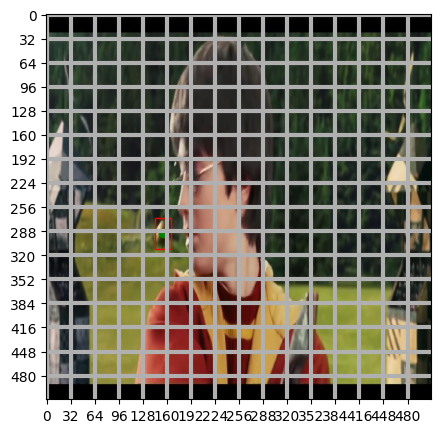

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Реализуйте аналогичные принципы, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами.

То есть, нужно проделать операции из collate_fn в обратную сторону.

In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    itog_mas = []
    if (c == 6):
      for i in range(b):
        now_bboxes = []
        for j in range(16):
          for k in range(16):
            if pred[i, 4, j, k] >= threshold:
              cx_idx = j
              cy_idx = k
              w_usual = pred[i, 2, j, k] * 512
              h_usual = pred[i, 3, j, k] * 512
              classes = pred[i, 5, j, k]
              cx_box = pred[i, 0, j, k]
              cy_box = pred[i, 1, j, k]

              x_centr = cx_idx * upsample + cx_box * upsample
              y_centr = cy_idx * upsample + cy_box * upsample

              xmin = x_centr - (w_usual / 2)
              xmax = x_centr + (w_usual / 2)
              ymin = y_centr - (h_usual / 2)
              ymax = y_centr + (h_usual / 2)
              now_bboxes.append([xmin, ymin, xmax, ymax, classes])
        itog_mas.append(now_bboxes)
    else:
      for i in range(b):
        now_bboxes = []
        for j in range(16):
          for k in range(16):
            if pred[i, 4, j, k] >= threshold:
              cx_idx = j
              cy_idx = k
              w_usual = pred[i, 2, j, k] * 512
              h_usual = pred[i, 3, j, k] * 512
              classes = torch.argmax(torch.tensor([pred[i, 5, j, k], pred[i, 6, j, k], pred[i, 7, j, k]])).item()
              cx_box = pred[i, 0, j, k]
              cy_box = pred[i, 1, j, k]

              x_centr = cx_idx * upsample + cx_box * upsample
              y_centr = cy_idx * upsample + cy_box * upsample

              xmin = x_centr - (w_usual / 2)
              xmax = x_centr + (w_usual / 2)
              ymin = y_centr - (h_usual / 2)
              ymax = y_centr + (h_usual / 2)
              now_bboxes.append([xmin, ymin, xmax, ymax, classes])
        itog_mas.append(now_bboxes)
    return itog_mas

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 вклюяительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [ ]:
C =  3

class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.conv(x)

class SmallConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv(x)

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model_res = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT) #на выходе 1000
        model_res_cut = nn.Sequential(*list(model_res.children())[0:8])
        self.down = model_res_cut
        self.up = nn.Sequential(
          ConvBlock(2048, 512),
          ConvBlock(512, 128),
          ConvBlock(128, 32),
          SmallConvBlock(32, 8),
          )

        self.targets = torch.Tensor()
        self.preds = torch.Tensor()


    def forward(self, images):
        output = self.down(images)
        output = self.up(output)

        return output

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)

* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [ ]:
def special_loss(pred, target, check=False, C=C, device = "cuda"):
    pred_last = torch.stack([pred[:, 5, :, :], pred[:, 6, :, :], pred[:, 7, :, :]]).permute((1,0,2,3))
    b, p ,w, h = pred.shape
    mse_los = torch.nn.MSELoss(reduction ='sum')
    cross_entropy_los = nn.CrossEntropyLoss(reduction ='sum')

    mask = target[:,4, : ,:].unsqueeze(1) > 0
    mask_no = target[:,4, : ,:].unsqueeze(1) < 1

    new_target_loc_los = torch.masked_select(target[:, 0:2, :, :], mask)
    new_pred_loc_los = torch.masked_select(pred[:, 0:2, :, :], mask).type(torch.LongTensor).to(device)
    pre_loc_los = mse_los(new_pred_loc_los, new_target_loc_los)

    new_target_box_los = torch.masked_select(target[:, 2:4, :, :], mask)
    new_pred_box_los = torch.masked_select(pred[:, 2:4, :, :], mask)
    pre_box_los = mse_los(torch.sqrt(new_pred_box_los), torch.sqrt(new_target_box_los))

    new_pred_clas_los = torch.stack([torch.masked_select(pred_last[:, :1, :, :], mask), torch.masked_select(pred_last[:, 1:2, :, :], mask),
                                     torch.masked_select(pred_last[:, 2:, :, :], mask)]).permute(1,0)
    new_target_clas_los = torch.masked_select(target[:, 5:6, :, :], mask).type(torch.LongTensor).to(device)
    pre_clas_los = torch.nan_to_num(cross_entropy_los(new_pred_clas_los, new_target_clas_los))

    new_target_det_conf_los = torch.masked_select(target[:, 4:5, :, :], mask)
    new_pred_det_conf_los = torch.masked_select(pred[:, 4:5, :, :], mask)
    new_target_no_det_conf_los = torch.masked_select(target[:, 4:5, :, :], mask_no)
    new_pred_no_det_conf_los = torch.masked_select(pred[:, 4:5, :, :], mask_no)
    pre_conf_no = F.binary_cross_entropy(new_pred_no_det_conf_los, new_target_no_det_conf_los, reduction ='sum')
    pre_comf_yee = F.binary_cross_entropy(new_pred_det_conf_los, new_target_det_conf_los, reduction ='sum')
    pre_conf_los = 0.1 * torch.nan_to_num(pre_conf_no) + torch.nan_to_num(pre_comf_yee)
    # print("aa", pre_loc_los, pre_box_los, pre_clas_los, pre_conf_los)
    if not check:
        return pre_loc_los + pre_box_los + pre_clas_los + pre_conf_los

    else:
        return pre_loc_los, pre_box_los, pre_clas_los, pre_conf_los

In [ ]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 6, 16, 16), device = "cpu"), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, batch_size=6, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 30
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr = 0.001)

for e in tqdm(range(EPOCHS)):
    epoch_losses = []
    pbar = tqdm(loader, leave=False)
    for batch in pbar:
        img, target = batch["image"].to(device), batch["target"].to(device)
        out = model(img)
        loss = special_loss(out, target)
        loss.backward()
        opt.step()
        opt.zero_grad()
        pbar.set_description(f"Loss: {round(loss.item(), 4)} ")
        epoch_losses.append(loss.item())
    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 0 done; Train loss 51.247;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 1 done; Train loss 36.472;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 2 done; Train loss 36.172;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 3 done; Train loss 35.547;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 4 done; Train loss 35.755;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 5 done; Train loss 34.828;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 6 done; Train loss 34.047;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 7 done; Train loss 33.439;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 8 done; Train loss 31.892;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 9 done; Train loss 30.972;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 10 done; Train loss 29.301;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 11 done; Train loss 28.148;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 12 done; Train loss 27.260;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 13 done; Train loss 26.217;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 14 done; Train loss 24.069;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 15 done; Train loss 23.398;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 16 done; Train loss 22.652;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 17 done; Train loss 22.202;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 18 done; Train loss 20.029;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 19 done; Train loss 18.291;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 20 done; Train loss 16.108;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 21 done; Train loss 15.558;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 22 done; Train loss 15.234;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 23 done; Train loss 14.337;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 24 done; Train loss 14.680;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 25 done; Train loss 13.364;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 26 done; Train loss 12.104;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 27 done; Train loss 11.794;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 28 done; Train loss 11.699;


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch 29 done; Train loss 10.776;


Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
with torch.no_grad():
    pred = model(batch['image'].to(device)).to('cpu')

In [ ]:
bboxes = decode_prediction(pred, threshold=0.51)

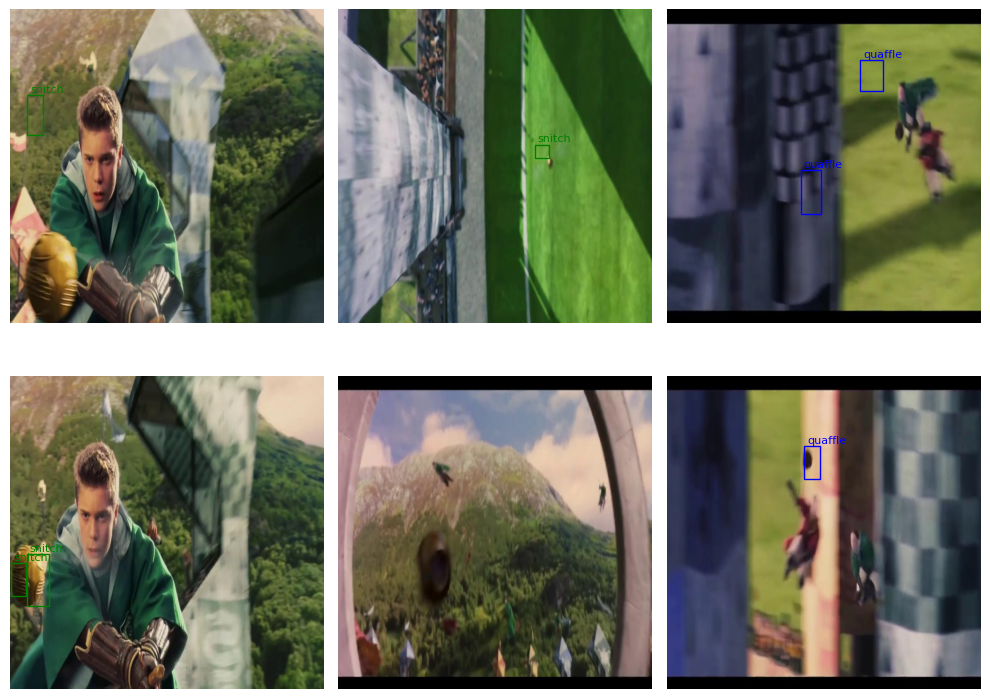

In [ ]:
visualize([batch["image"][i] for i in range(6)], [bboxes[i] for i in range(6)])

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [ ]:
!pip install ultralytics

## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    itog_mas = []
    for i in bboxes:
      now_str = ""
      now_str += str(i[4])
      now_str += " "
      now_str += str((i[0] + i[2]) / (2*w_im))
      now_str += " "
      now_str += str((i[1] + i[3])/ (2*h_im))
      now_str += " "
      now_str += str((i[2] - i[0]) / w_im)
      now_str += " "
      now_str += str((i[3] - i[1]) / h_im)
      itog_mas.append(now_str)
    return itog_mas

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc =  3 # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names =  ['snitch', 'quaffle', 'bludger']# Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [ ]:
import ultralytics
device = "cuda"
model = ultralytics.YOLO('yolov8n.yaml')
results = model.train(data='data.yaml', epochs=100, imgsz=512)

## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

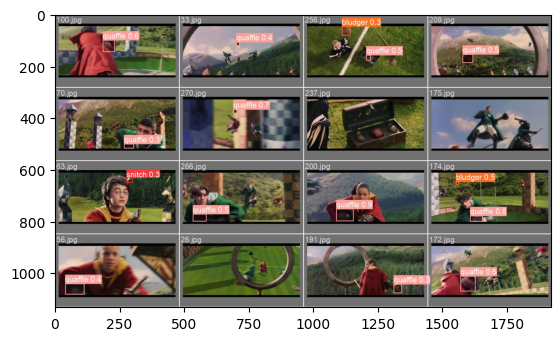

In [ ]:
image = Image.open("/content/runs/detect/train/val_batch0_pred.jpg").convert("RGB")
plt.imshow(image)
plt.show()